# Multi-Layer Perceptron

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Generate Data

In [8]:
class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """ Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data = np.random.uniform(0, 1, (n, 2))

        inputs = []
        labels = []

        for point in data:
            inputs.append([point[0], point[1]])

            if point[0] > point[1]:
                labels.append(0)
            else:
                labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """ Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def fetch_data(mode, n):
        """ Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == 'Linear' or mode == 'XOR'

        data_gen_func = {
            'Linear': GenData._gen_linear,
            'XOR': GenData._gen_xor
        }[mode]

        return data_gen_func(n)

## MLP Implementation

In [9]:
class MLP:
    def __init__(self, listOfLayers):
        self.layers = [{} for i in range(len(listOfLayers))]
        
        for i in range(1, len(listOfLayers)):
            self.layers[i]['w'] = np.random.randn(listOfLayers[i-1], listOfLayers[i])
            self.layers[i]['b'] = np.random.randn(1, listOfLayers[i])
            
        self.lossList = []
        
        return
    
    def forward(self, x):
        self.layers[0]['a'] = np.copy(x)
        
        for i in range(1, len(self.layers)):
            self.layers[i]['z'] = np.dot(self.layers[i-1]['a'], self.layers[i]['w']) + self.layers[i]['b']
            self.layers[i]['a'] = self.activation(self.layers[i]['z'])
            
        return np.where(self.layers[-1]['a'] > 0.5, 1, 0)
            
    def backProp(self, y, bs):
        self.layers[-1]['dJda'] = -y/self.layers[-1]['a'] + (1.0-y)/(1.0-self.layers[-1]['a'])
            
        for i in range(len(self.layers)-1, 0, -1):
            self.layers[i]['dJdz'] = self.inverseActivation(self.layers[i]['a']) * self.layers[i]['dJda']
            self.layers[i]['dJdb'] = np.mean(self.layers[i]['dJdz'], axis=0)
            self.layers[i]['dJdw'] = np.dot(self.layers[i-1]['a'].T, self.layers[i]['dJdz']) / bs
            self.layers[i-1]['dJda'] = np.dot(self.layers[i]['dJdz'], self.layers[i]['w'].T)
            
        return
    
    def update(self, learning_rate=0.01):
        for i in range(1, len(self.layers)):
            self.layers[i]['w'] -= learning_rate * self.layers[i]['dJdw']
            self.layers[i]['b'] -= learning_rate * self.layers[i]['dJdb']
        return
    
    def activation(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def inverseActivation(self, a):
        return a*(1.0 - a)
    
    def shuffle(self, X, Y):
        shuffled_X, shuffled_Y = np.copy(X), np.copy(Y)
        shuffled_idx = np.random.permutation(X.shape[0])
        return shuffled_X[shuffled_idx, :], shuffled_Y[shuffled_idx, :]
    
    def loss(self, y):
        return np.mean(-np.log(self.layers[-1]['a'])*y - np.log(1.0 - self.layers[-1]['a'])*(1.0 - y))
    
    def train(self, trainX, trainY, numEpoch=10, lr=0.01, bs=10):
        for e in range(numEpoch):
            shuffled_trainX, shuffled_trainY = self.shuffle(trainX, trainY)
            for i in range(trainX.shape[0] // bs):
                x = shuffled_trainX[i*bs:(i+1)*bs, :]
                y = shuffled_trainY[i*bs:(i+1)*bs, :]
                self.yHat = self.forward(x)
                self.lossList.append(self.loss(y))
                self.backProp(y, bs)
                self.update(lr)
        return

## Train & Test on Linear Data (training: 100,000, testing: 10,000)

### Trainging & Testing

In [10]:
np.random.seed(0)
mlp = MLP([2, 3, 3, 1])

trainX, trainY = GenData.fetch_data('Linear', 100000)
testX, testY = GenData.fetch_data('Linear', 10000)

mlp.train(trainX, trainY, 1, 0.1, 10)
mlp.train(trainX, trainY, 1, 0.01, 10)
mlp.train(trainX, trainY, 1, 0.001, 10)

preds = mlp.forward(testX)

### Evaluation & Result

In [11]:
acc = np.sum(np.where(testY==preds, 1, 0))/preds.size

TP = np.sum(testY & preds)
FP = np.sum(np.where(testY ^ preds, preds, 0))
FN = np.sum(np.where(testY ^ preds, testY, 0))
TN = np.sum(1 - (testY | preds))
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: {}'.format(acc))
print('----------')
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1 Score: {}'.format(f1_score))

Accuracy: 0.9992
----------
Recall: 0.9983929288871033
Precision: 1.0
F1 Score: 0.9991958182549256


Text(0.5,1,'Predictions')

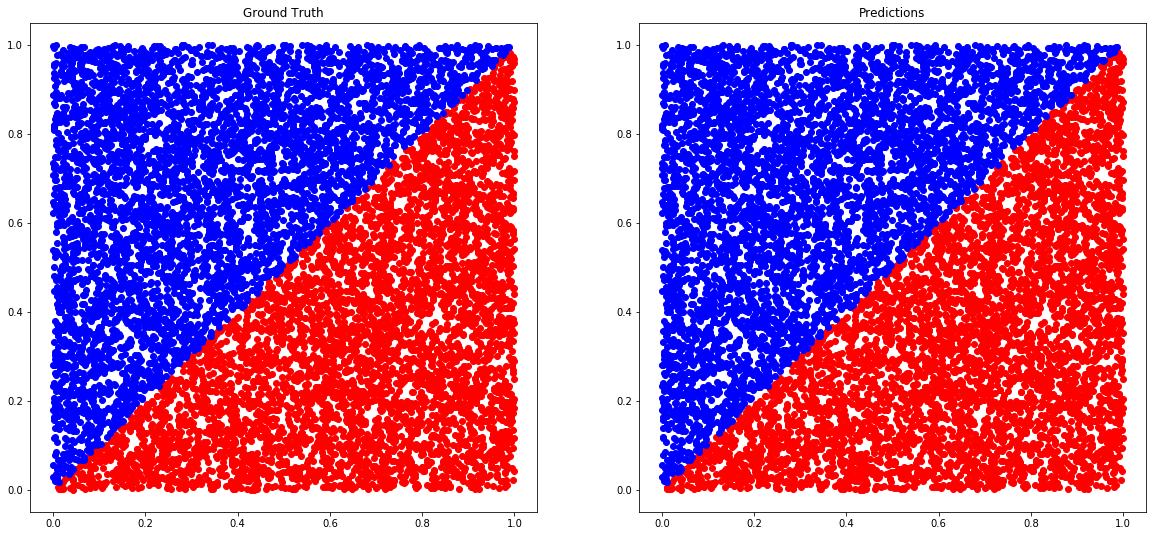

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 9)

# Ground Truth
red = np.where(testY==0)[0]
blue = np.where(testY==1)[0]
ax1.plot(testX[red, 0], testX[red, 1], 'ro')
ax1.plot(testX[blue, 0], testX[blue, 1], 'bo')
ax1.set_title('Ground Truth')

# Prediction
red = np.where(preds==0)[0]
blue = np.where(preds==1)[0]
ax2.plot(testX[red, 0], testX[red, 1], 'ro')
ax2.plot(testX[blue, 0], testX[blue, 1], 'bo')
ax2.set_title('Predictions')

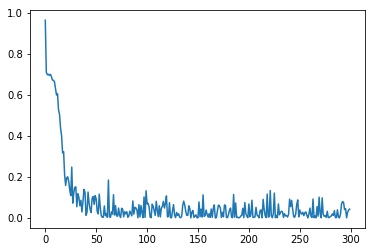

In [13]:
plt.plot(mlp.lossList[::100])

# Train & Test on XOR Data

## Training & Testing

In [14]:
np.random.seed(0)
mlp = MLP([2, 5, 5, 1])

trainX, trainY = GenData.fetch_data('XOR', 100000)
testX, testY = GenData.fetch_data('XOR', 10000)

mlp.train(trainX, trainY, 1, 0.1, 10)
mlp.train(trainX, trainY, 1, 0.01, 10)
mlp.train(trainX, trainY, 1, 0.001, 10)

preds = mlp.forward(testX)

## Evaluation & Result

In [15]:
acc = np.sum(np.where(testY==preds, 1, 0))/preds.size

TP = np.sum(testY & preds)
FP = np.sum(np.where(testY ^ preds, preds, 0))
FN = np.sum(np.where(testY ^ preds, testY, 0))
TN = np.sum(1 - (testY | preds))
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: {}'.format(acc))
print('----------')
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1 Score: {}'.format(f1_score))

Accuracy: 0.9865
----------
Recall: 0.973
Precision: 1.0
F1 Score: 0.9863152559553979


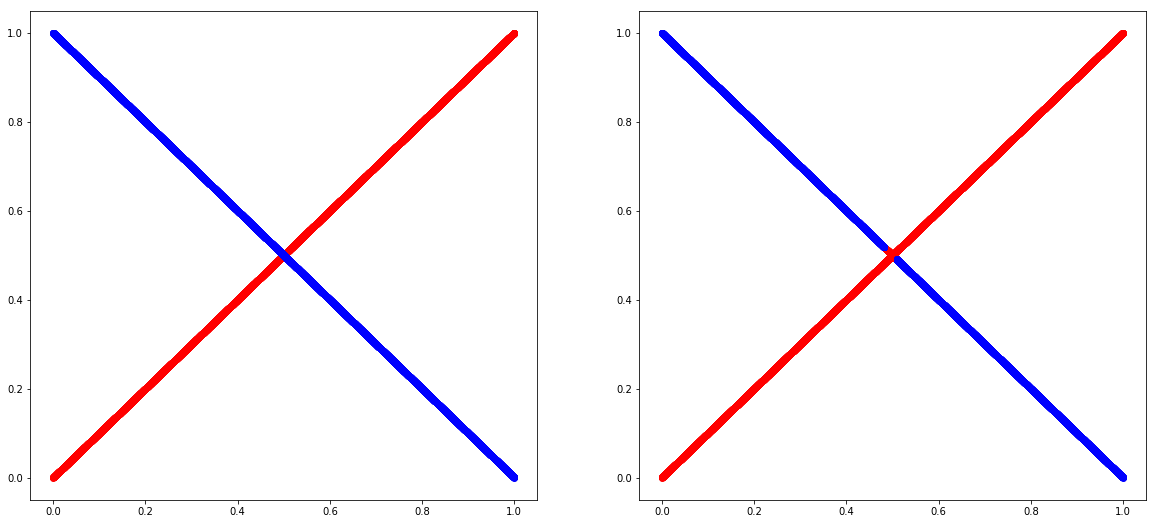

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 9)

# Ground Truth
red = np.where(testY==0)[0]
blue = np.where(testY==1)[0]
ax1.plot(testX[red, 0], testX[red, 1], 'ro')
ax1.plot(testX[blue, 0], testX[blue, 1], 'bo')

# Prediction
red = np.where(preds==0)[0]
blue = np.where(preds==1)[0]
ax2.plot(testX[red, 0], testX[red, 1], 'ro')
ax2.plot(testX[blue, 0], testX[blue, 1], 'bo')

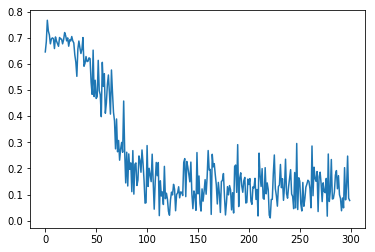

In [17]:
plt.plot(mlp.lossList[::100])